# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")
plt.style.use('ggplot')

## Data

The first dataset (sheetname=0) contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel('data/WineKMC.xlsx', sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("data/WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn
# join the offers and transactions table
df = pd.merge(df_offers, df_transactions)

# create a "pivot table" which will give us the number of times each customer responded to a given offer
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')

# fill NA values with 0 and make the index into a column
matrix = matrix.fillna(0).reset_index()

matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce three methods: __the Elbow method__, the __Silhouette method__, along with the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why? <br/>
 <b>$Answer$: </b> I think the smallest does. Because the distance between each points and the centroid point to a tighter cluster. The literature above states that the point of K-Means cluster is to minimize the distance between points while at the same time maximizing the distance between cluster centroids.
    
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?<br/>
    <b>Answer:</b> Based on literature surrounding the elbow method it is important to pick marginal increases of K up until the negative slope flattens: essentially this means that from 2 to 5 in the graph below you can see that the negative slope is steep up until 5 it then flattens. The selection using the elbow method is rather subject as I could have selected k == 4 as well given the return between 4 and 5 is also small compared to return between 3 and 4. 
</ul>
</div>

In [5]:
# your turn

In [6]:
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
# Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
x_cols = matrix.columns[1:]
print(x_cols)

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32], dtype='object', name='offer_id')


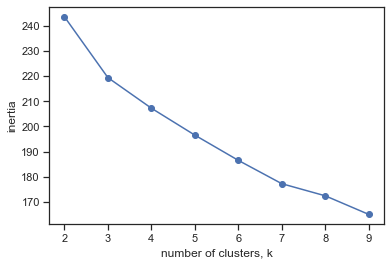

TypeError: 'KMeans' object is not callable

In [21]:
# Construct a plot showing  𝑆𝑆  for each  𝐾  and pick  𝐾  using this plot. 
# For simplicity, test  2≤𝐾≤10 .
ks = range(2, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model= KMeans(n_clusters=k) 
    
    # Fit model to samples
    model.fit(matrix[matrix.columns[2:]])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

# Pick k==5 as best K.
# Make a bar chart showing the number of points in each cluster for k-means under the best  𝐾 .
cluster5 = model(n_clusters=5) 
matrix['cluster5'] = cluster5.fit_predict(matrix[matrix.columns[2:]])
matrix_count = matrix.cluster5.value_counts() 


plt.bar(matrix_count.index, matrix_count.values)
plt.xlabel('cluster')
plt.ylabel('count')
plt.xticks(matrix_count.index)
plt.show()

In [ ]:
# import Kmeans library and setup best_cluster. 
from sklearn.cluster import KMeans
best_cluster = 5
cluster = KMeans(n_clusters=best_cluster)

# slice matrix so we only include the 0/1 indicator columns in the clustering
matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[2:]])
matrix.cluster.value_counts()
matrix.to_csv('data/matrix.csv')

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
<b>Answer:</b> The Silhouette score suggests either K==4 or K==5. However, the presence of clusters with below average silhouette scores for K==4 and k==5 may not be ideal due to wide fluctuations in the size of the silhouette plots. The Silhouette score for K==3 is not that far off from scores of 4 and 5, and all of the clusters are above average score and the size of the silhouette plots are more uniform.

</div>

In [9]:
# Your turn.
# import libraries
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2,3,4,5,6,7]

X = matrix[matrix.columns[2:]]

For n_clusters = 2 The average silhouette_score is : 0.09467039888175721
For n_clusters = 3 The average silhouette_score is : 0.11916585417703293
For n_clusters = 4 The average silhouette_score is : 0.13548216706907687
For n_clusters = 5 The average silhouette_score is : 0.10264839036585287
For n_clusters = 6 The average silhouette_score is : 0.11380360313965315
For n_clusters = 7 The average silhouette_score is : 0.11848720855802197


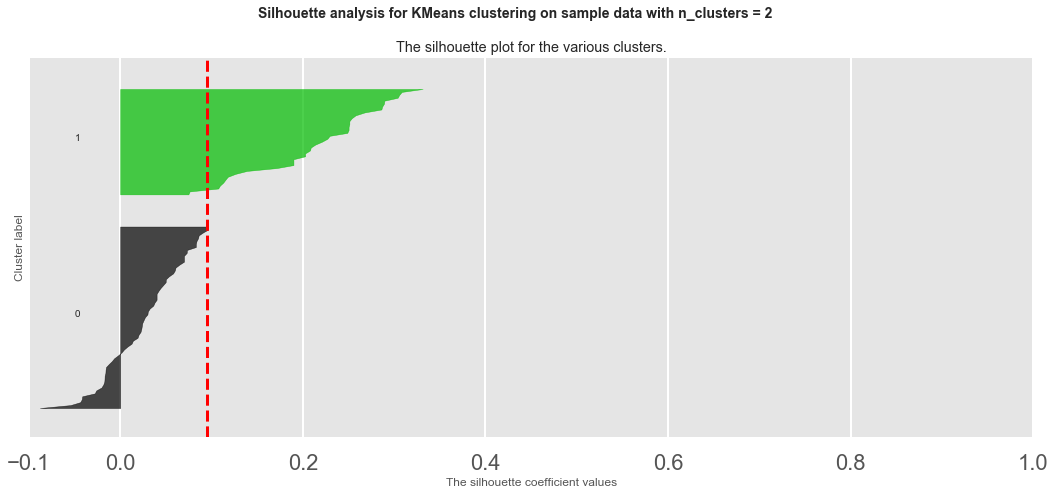

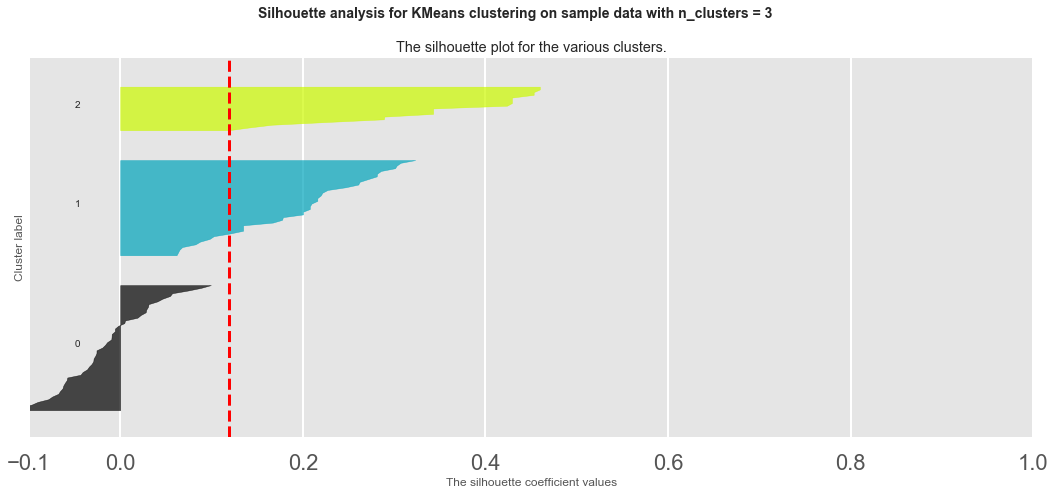

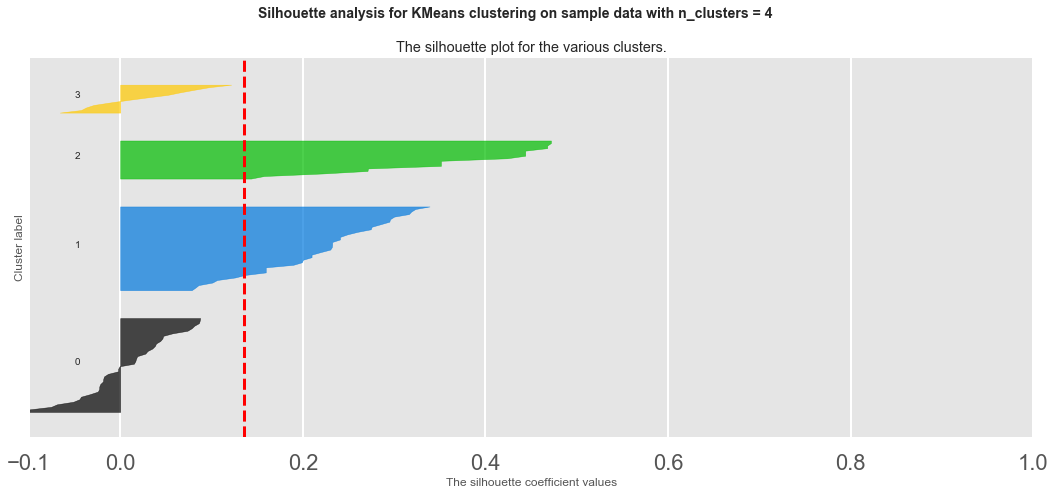

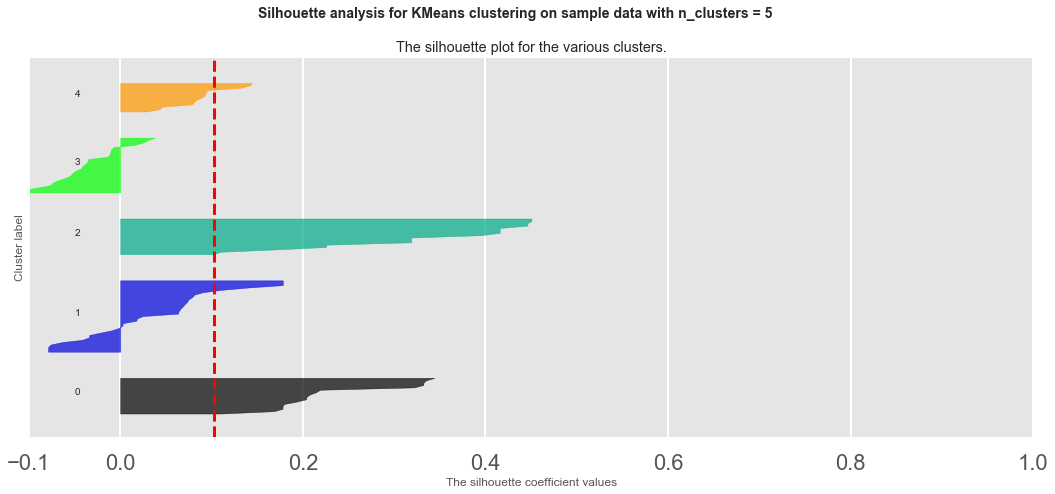

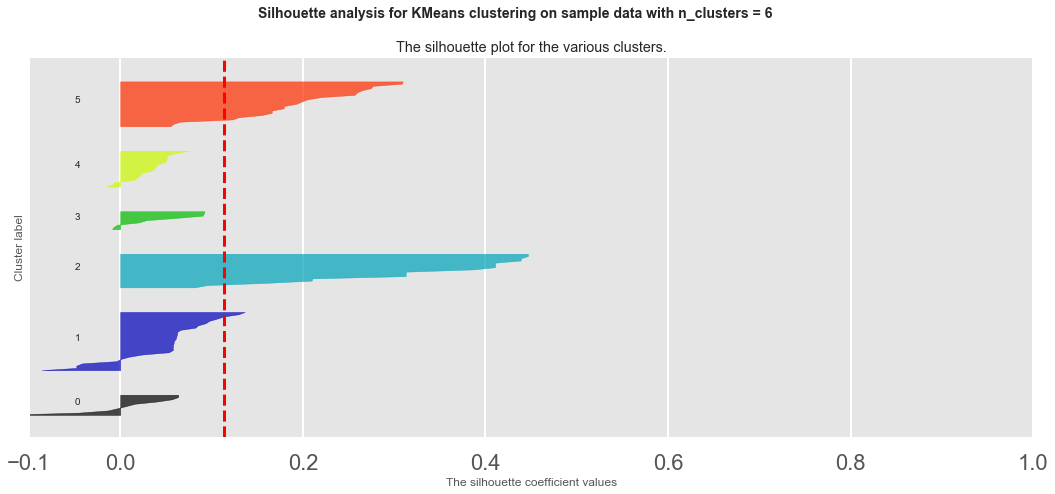

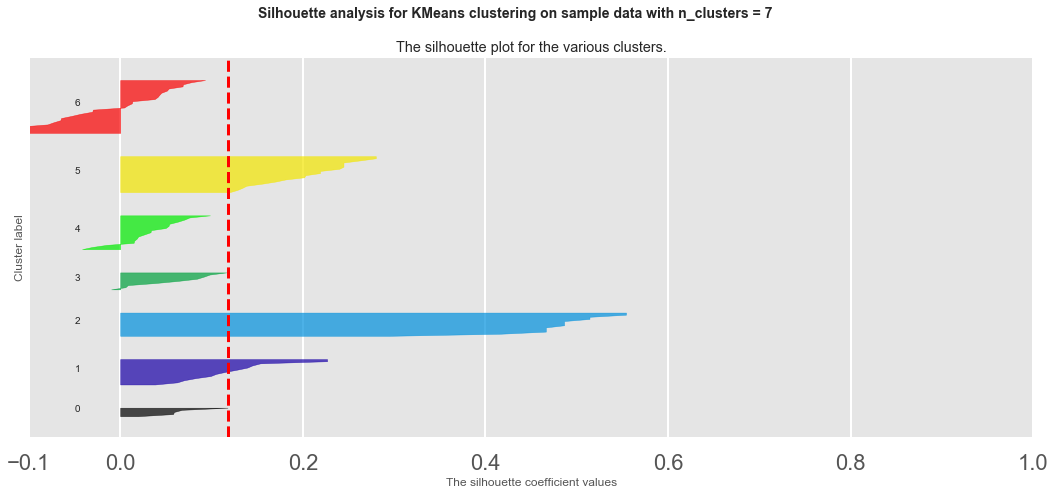

In [10]:
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row  
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
    <br/>
    <b>Answer: k==5 is best because each cluster id is separated out into visual clusters and appear to not overlap.<b/>
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
<p><b>Answer:</b> At a quick glance, I don't see much distinguishing characteristics of first 4 clusters. 5th cluster is all Pinot Noir varietal. </p>
</div>

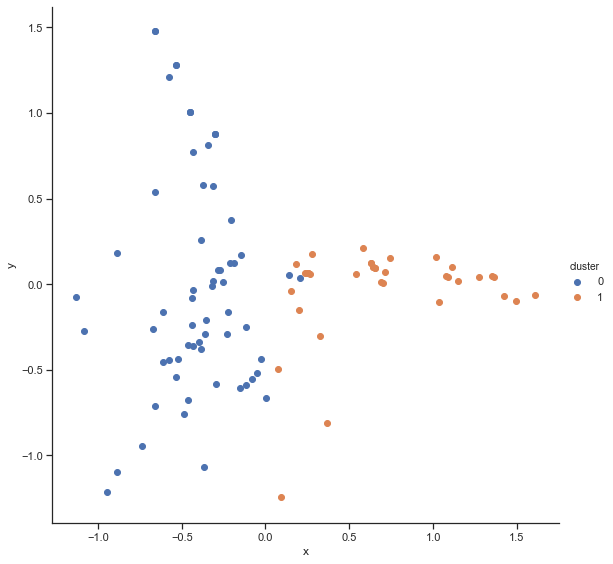

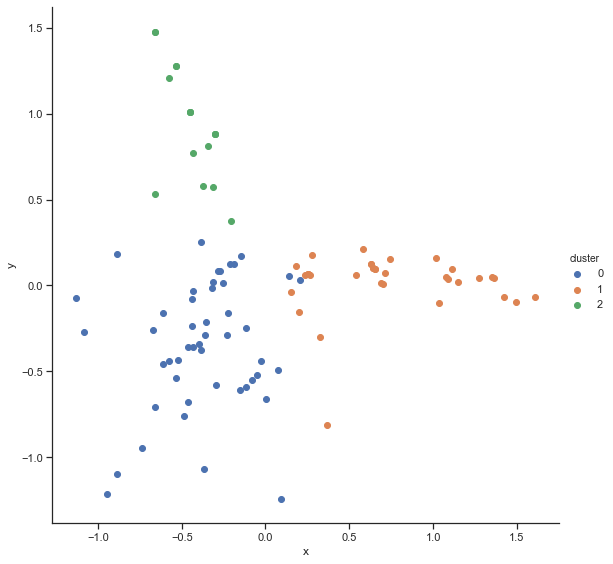

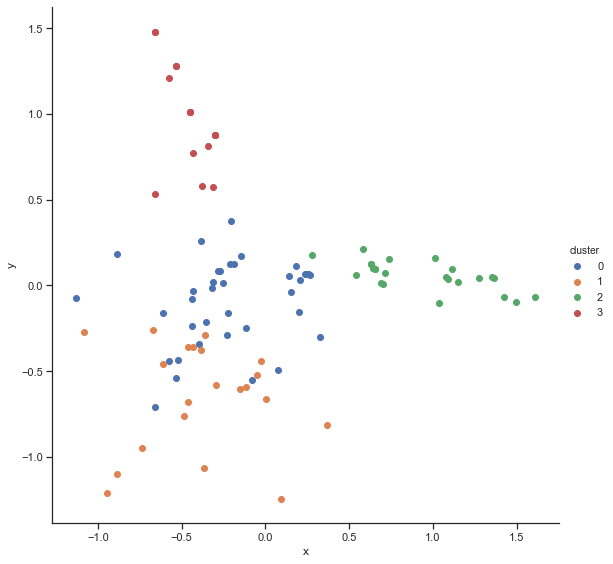

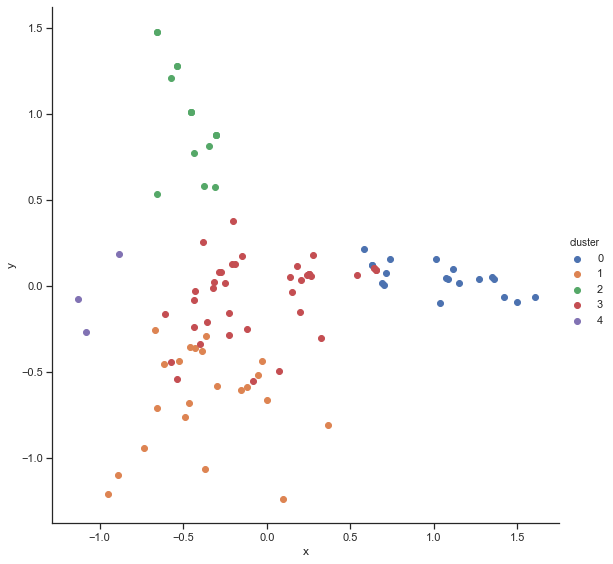

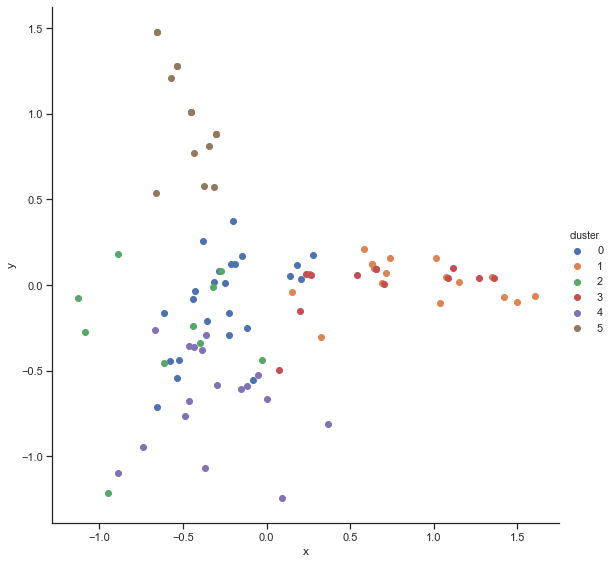

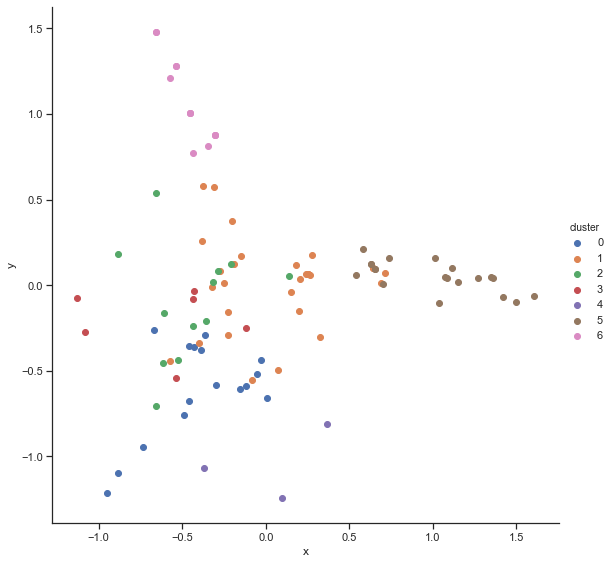

In [11]:
#your turn
# Note for myself: used https://sepans.github.io/weather-mining/method.html 
# Note for myself: dynamic color https://stackoverflow.com/questions/14885895/color-by-column-values-in-matplotlib 
# Import PCA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from  matplotlib import pyplot
import seaborn

# Create PCA instance: model
model = PCA(n_components=2)

# Apply the fit_transform method of model to grains: pca_features
data = matrix[matrix.columns[2:]]
pca_features = model.fit_transform(data)
pca_df = pd.DataFrame(pca_features)
pca_df.index = matrix.index
pca_df.columns = ['x','y']

pca_df['customer_name'] = matrix['customer_name']

# get cluster by kmeans - try from k==2 to 7
ks = range(2, 8) 

for k in ks:
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit(data)
    # add cluster info to pca output
    pca_df['cluster'] = pd.Series(clusters.labels_, index=pca_df.index)

    # My choice of best k is 5 so saving result in csv.
    if(k==5):
        pca_df.to_csv('data/with_pc.csv')
        
    # graph
    seaborn.set(style='ticks')
    _hueorder= range(k) 
    fg = seaborn.FacetGrid(data=pca_df, hue='cluster', hue_order=_hueorder, aspect=1, height=8)
    fg.map(pyplot.scatter, 'x', 'y').add_legend()

In [12]:
# Look at both the original raw data about the offers and transactions and look at the fitted clusters. 
# Tell a story about the clusters in context of the original data. 
# For example, do the clusters correspond to wine variants or something else interesting?
# read in matrix.csv - has matrix df plus cluster id when k==5
df_matrix = pd.read_csv("data/matrix.csv")

df_matrix = df_matrix[df_matrix.columns[2:]]

df_matrix.head()

# to do :
# 1. Get total number of each offers per cluster? - see what sticks out? 

cluster_0 = df_matrix[df_matrix.cluster == 0]
cluster_1 = df_matrix[df_matrix.cluster == 1]
cluster_2 = df_matrix[df_matrix.cluster == 2]
cluster_3 = df_matrix[df_matrix.cluster == 3]  
cluster_4 = df_matrix[df_matrix.cluster == 4] 



Text(0.5, 1.0, 'cluster 4')

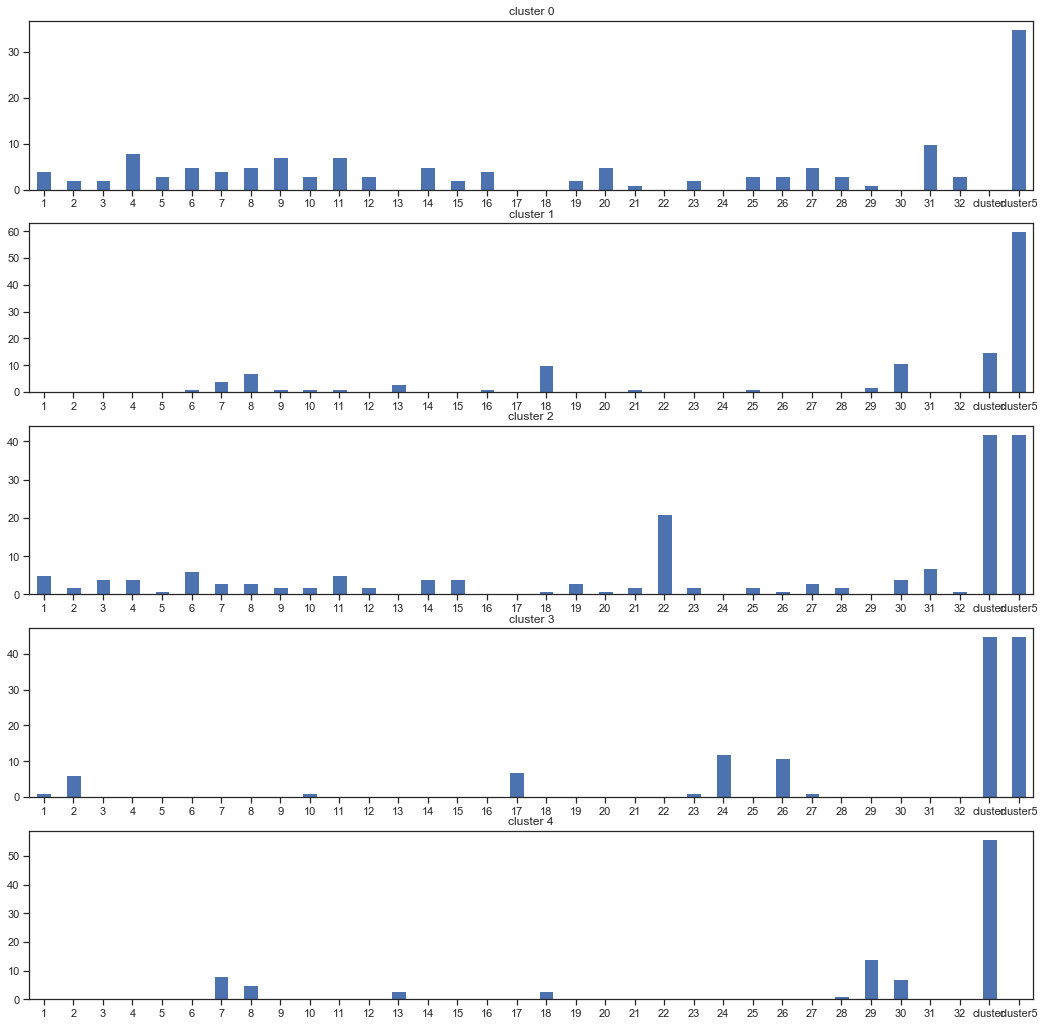

In [13]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, ncols=1, figsize=(18,18)) 

cluster_0_sum = cluster_0.sum(axis = 0, skipna = True)
cluster_0_sum.plot.bar(rot=0, ax=ax1)
ax1.set_title("cluster 0")

cluster_1_sum = cluster_1.sum(axis = 0, skipna = True)
cluster_1_sum.plot.bar(rot=0, ax=ax2)
ax2.set_title("cluster 1")

cluster_2_sum = cluster_2.sum(axis = 0, skipna = True)
cluster_2_sum.plot.bar(rot=0, ax=ax3)
ax3.set_title("cluster 2")

cluster_3_sum = cluster_3.sum(axis = 0, skipna = True)
cluster_3_sum.plot.bar(rot=0, ax=ax4)
ax4.set_title("cluster 3")

cluster_4_sum = cluster_4.sum(axis = 0, skipna = True)
cluster_4_sum.plot.bar(rot=0, ax=ax5)
ax5.set_title("cluster 4")

# If you don't do tight_layout() you'll have weird overlaps
#plt.tight_layout()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
<b>Answer:</b> The below chart shows a sharp decline after the 2nd feature so in this case the best value for optional number of dimensions is 2.
</div>

[0.14566433 0.11101771 0.06900688 0.05861038 0.05446522 0.05174642
 0.04950267 0.04328258 0.03975941 0.03620822 0.03583051 0.03378997
 0.03131593 0.02628913 0.02381611 0.02158946 0.02033022 0.01867676
 0.01604445 0.01510505 0.01385464 0.01303214 0.01175153 0.01110971
 0.00962806 0.00944574 0.0078552  0.00691052 0.00634145 0.0051764
 0.0028432 ]


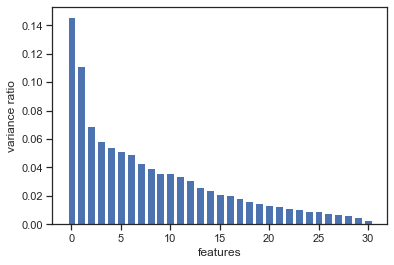

In [14]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)
print(pca.explained_variance_ratio_) 

plt.bar(range(pca.explained_variance_ratio_.size), pca.explained_variance_ratio_)
plt.xlabel('features')
plt.ylabel('variance ratio') 
plt.show()

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>

<p>
<b>Answer:</b><br/>
Affinity propagation didn't need to reduce the number of dimensions by PCA. It was able to provide estimated numnber of clusters by similarity. 
<br/>
 <br/>
Spectral clustering benefited from dimension reduction making it easier to plot the clusters. It was helpful to plot the clusters, otherwise, it would have been difficult to determine what number of clusters is optimal. Same was true to Agglomerative clustering. Between the two methods, even though they agree on number of clusters, except for when k==5, the membership of the clusters did not match. 
<br/>
 <br/>
With DBSCAN, once optimal eps value is picked, based on min_samples, number of cluster varied. Even though min_samples was changed to produce 5 clusters which seem to be the optimal number of clusters, the membership of the clusters did not separate out according to the clusters visualized via plot. 
</p>
</div>



In [15]:
from sklearn.neighbors import NearestNeighbors

# Reduce dimension to 2 for simpler visualization
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_principal)
distances, indices = nbrs.kneighbors(X_principal)


colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

In [16]:
# Your turn
# Affinity Propagation
# https://medium.com/@aneesha/using-affinity-propagation-to-find-the-number-of-clusters-in-a-dataset-52f5dd3b0760
from sklearn.cluster import AffinityPropagation

# run model using all dimensions
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

no_clusters = len(cluster_centers_indices)

print('Estimated number of clusters with all dimensions: %d' % no_clusters)  

# Do another run with dimensions reduced via PCA
af1 = AffinityPropagation(preference=-50).fit(X_principal)
cluster_centers_indices1 = af1.cluster_centers_indices_
labels1 = af1.labels_

no_clusters1 = len(cluster_centers_indices1)
print('Estimated number of clusters with dimensions reduced to 2 via PCA: %d' % no_clusters1)  


Estimated number of clusters with all dimensions: 1
Estimated number of clusters with dimensions reduced to 2 via PCA: 1


C:\Users\alfre\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


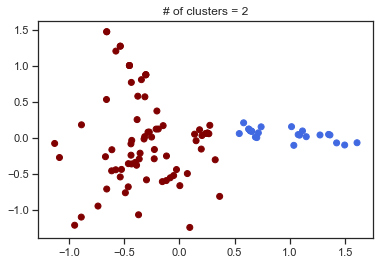

C:\Users\alfre\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


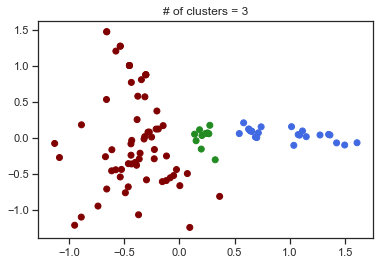

C:\Users\alfre\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


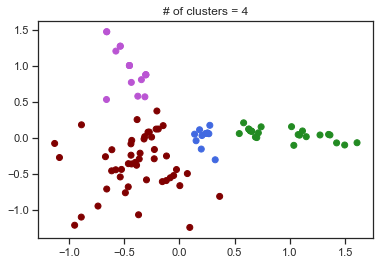

C:\Users\alfre\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


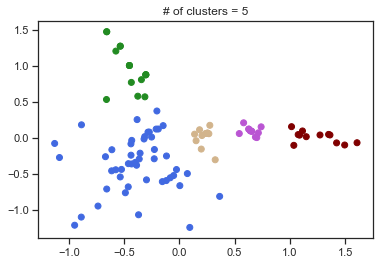

C:\Users\alfre\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


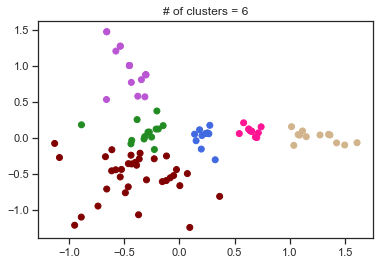

C:\Users\alfre\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


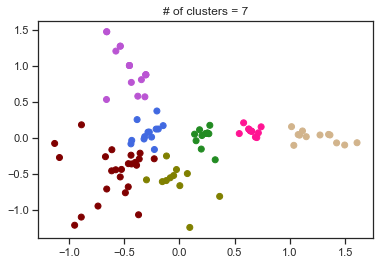

In [17]:
# Spectral clustering
# https://medium.com/@tomernahshon/spectral-clustering-from-scratch-38c68968eae0
from sklearn.cluster import SpectralClustering

# get cluster by features - try from f==2 to 7
fs = range(2, 8) 

for f in fs:
    model = SpectralClustering(n_clusters=f, affinity='nearest_neighbors',
                          assign_labels='kmeans')
    clusters = model.fit_predict(X_principal)

    plt.scatter(X_principal['P1'], X_principal['P2'], c=vectorizer(clusters))
    plt.title('# of clusters = ' + str(f))
    plt.show()

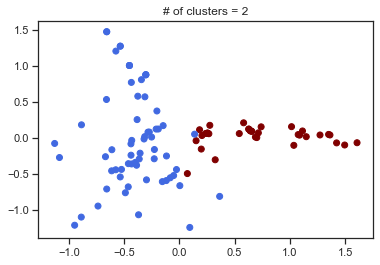

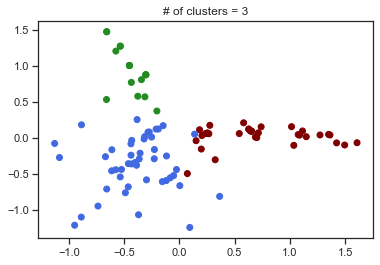

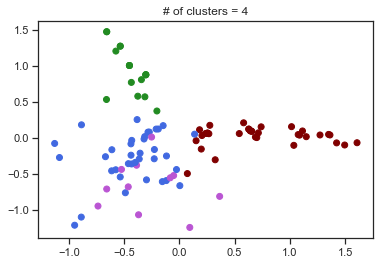

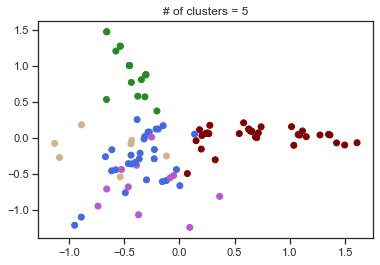

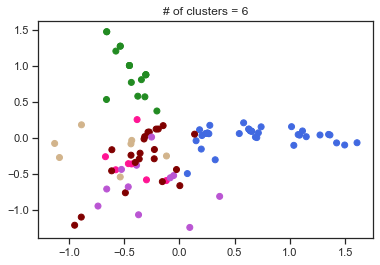

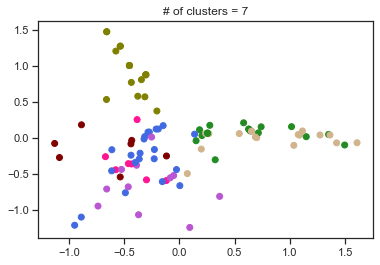

In [18]:
# Agglomerative clustering
# https://trainingdatascience.com/workshops/hierarchical-clustering---agglomerative/
from sklearn.cluster import AgglomerativeClustering


# get cluster by features - try from f==2 to 7
fs = range(2, 8) 

for f in fs:
    clt = AgglomerativeClustering(linkage='ward',n_clusters=f)

    # Train model
    model = clt.fit(X) 
    clusters = model.labels_
    #unique, counts = np.unique(model.labels_, return_counts=True)
        
    plt.scatter(X_principal['P1'], X_principal['P2'], c=vectorizer(clusters))
    plt.title('# of clusters = ' + str(f))
    plt.show()

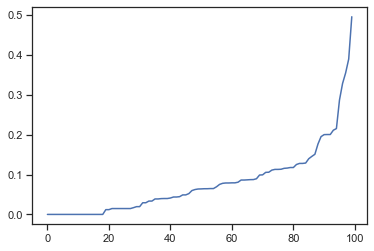

In [19]:
# DBSCAN
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

# Find optimal eps value first.
from sklearn.cluster import DBSCAN 
from sklearn.neighbors import NearestNeighbors


pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_principal)
distances, indices = nbrs.kneighbors(X_principal)

# We can calculate the distance from each point to its closest neighbour using the NearestNeighbors. 
# The point itself is included in n_neighbors. 
# The kneighbors method returns two arrays, one which contains the distance to the closest n_neighbors points and the other which contains the index for each of those points.
# The optimal value for epsilon will be found at the point of maximum curvature.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

[-1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  0 -1  1  0 -1 -1  1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  0 -1 -1
 -1 -1 -1 -1]


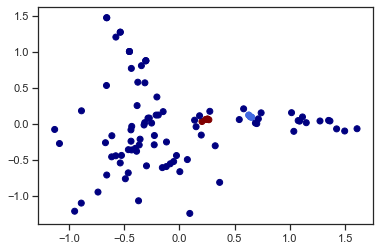

In [20]:
# run DBSCAN with optinal eps.

# produces 5 clusters
db = DBSCAN(eps = 0.05, min_samples = 5).fit(X_principal)
clusters = db.labels_ 
print(clusters)


colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.scatter(X_principal['P1'], X_principal['P2'], c=vectorizer(clusters))